In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

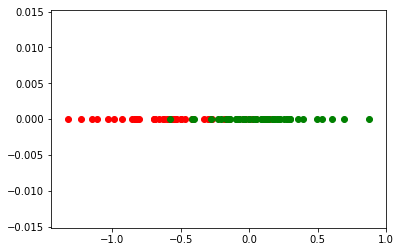

In [2]:

random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append([x+s*math.cos(theta)])
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,x,r))
    return clusters

n = 50
X = rand_clusters(2,50,0.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n]))
# label = np.array([1]*n + [0]*n)
# print (data, label)

plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [3]:
# tf.reset_default_graph()

# def weight_variable(shape, name):
#     initial = tf.truncated_normal(shape=shape, stddev=0.1)
#     return tf.get_variable(name=name, initializer=initial)

# def bias_variable(shape, name):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 2
n_output = 1
lmd = 0

parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.zeros([n_hidden]),\
                                    tf.truncated_normal([n_hidden * n_output]), tf.zeros([n_output]),\
                                   ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.nn.relu(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.relu(tf.matmul(hidden, weights2) + biases2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [4]:

def get_accuracy():
    pred = sess.run(y, feed_dict={x: data, y_: label})    
    match = [(pred[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad():
    nng = 0.
    for gv in grad:
#         print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        g = sess.run(gv, feed_dict={x: data, y_: label})
#         print (g)
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()


In [10]:
# 太巧合了！ 绝对不能改！
w0 = np.array([0,0.3,
              2,0.5,
              1,1.1,
              0.3])
private_init = parameters.assign(w0)

sess = tf.InteractiveSession()
l = 0.25 # learning rate 可以随便改
dic = {}
for _ in range(1):

    tf.global_variables_initializer().run()
    sess.run(private_init)    
    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
    nng = get_norm_grad()
    print (sess.run(grad[0], feed_dict={x: data, y_: label}))
#     print (w)
#     h = sess.run([y], feed_dict={x: data, y_: label})    
#     displayH(h)
    
    for i in range(10):
        sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
        
#         if i % 1 == 0:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
        nng = get_norm_grad()
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
        print (sess.run(grad[0], feed_dict={x: data, y_: label}))
        print (w)
#         h = sess.run([y], feed_dict={x: data, y_: label})    
#         displayH(h)
sess.close() 

[-0.55369854 -0.60906827  4.5541687   5.00958586  9.1083374   2.11097527
  4.5541687 ]
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.473, high_eig 0, low_eig 0.
[ 0.  0.  0.  0.  0.  0.  0.]
[ 0.13842463  0.45226708  0.86145782 -0.75239646 -1.27708435  0.57225621
 -0.83854216]
Epoch 2, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.473, high_eig 0, low_eig 0.
[ 0.  0.  0.  0.  0.  0.  0.]
[ 0.13842463  0.45226708  0.86145782 -0.75239646 -1.27708435  0.57225621
 -0.83854216]
Epoch 3, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.473, high_eig 0, low_eig 0.
[ 0.  0.  0.  0.  0.  0.  0.]
[ 0.13842463  0.45226708  0.86145782 -0.75239646 -1.27708435  0.57225621
 -0.83854216]
Epoch 4, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.473, high_eig 0, low_eig 0.
[ 0.  0.  0.  0.  0.  0.  0.]
[ 0.13842463  0.45226708  0.86145782 -0.75239646 -1.27708435  0.57225621
 -0.83854216]
Epoch 5, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.473, high_eig 0, low_eig 0.
[ 0.  0.  0.  0.  0.  0.  0.]
[ 0.1

In [204]:
sess = tf.InteractiveSession()
l = 0.25
dic = {}

for _ in range(100):
    
    flag = 1
    tf.global_variables_initializer().run()

    for i in range(1000):
        sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
        nng = get_norm_grad()
        if nng < 1e-4:
            flag = 1
            break

    if flag == 1:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
        nng = get_norm_grad()
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
#             h = sess.run([y], feed_dict={x: data, y_: label})    
#             print (h)
sess.close() 

Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.245, high_eig 0, low_eig 0.
Epoch 1000, accuracy 84.00%, loss 0.108627, nng 0.0006215, nnw 0.9314, high_eig 4.004, low_eig -0.0007287.
Epoch 591, accuracy 86.00%, loss 0.118555, nng 9.736e-05, nnw 0.7415, high_eig 7.86, low_eig -4.711e-05.
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.682, high_eig 0, low_eig 0.
Epoch 176, accuracy 84.00%, loss 0.108471, nng 9.67e-05, nnw 1.048, high_eig 3.629, low_eig 0.
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.494, high_eig 0, low_eig 0.
Epoch 357, accuracy 50.00%, loss 0.500000, nng 9.996e-05, nnw 1.647, high_eig 0.05061, low_eig -6.79e-05.
Epoch 499, accuracy 86.00%, loss 0.118556, nng 9.985e-05, nnw 1.018, high_eig 4.636, low_eig -3.178e-05.
Epoch 330, accuracy 86.00%, loss 0.118555, nng 9.867e-05, nnw 1.056, high_eig 4.184, low_eig 0.
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.176, high_eig 0, low_eig 0.
Epoch 318, accuracy 50.00%, loss 0.500000, nng 9.899e-05, 

Epoch 1000, accuracy 84.00%, loss 0.108607, nng 0.007093, nnw 1.401, high_eig 7.929, low_eig -0.002277.
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.8421, high_eig 0, low_eig 0.
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.461, high_eig 0, low_eig 0.
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.705, high_eig 0, low_eig 0.
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.224, high_eig 0, low_eig 0.
Epoch 371, accuracy 50.00%, loss 0.500000, nng 9.98e-05, nnw 1.65, high_eig 0.04222, low_eig -7.72e-05.
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.7313, high_eig 0, low_eig 0.
Epoch 279, accuracy 86.00%, loss 0.118555, nng 9.989e-05, nnw 0.871, high_eig 4.508, low_eig 0.
Epoch 173, accuracy 50.00%, loss 0.500000, nng 9.76e-05, nnw 0.3043, high_eig 0.1062, low_eig -2.599e-05.
Epoch 698, accuracy 86.00%, loss 0.118555, nng 9.959e-05, nnw 1.683, high_eig 4.851, low_eig -0.0001166.
Epoch 493, accuracy 86.00%, loss 0.118556, nng 9.964e-05, nnw 1.438, high

3.19:

Relu is helpful to obtain flat region. For example, zero is not a first order stationary point while using sigmoid, but indeed is while using relu.
    
For sigmoid, point far away from 0 tends to have tiny gradient.
